# Dead Leaves - Synthetic Images Generation

Description of the jupyter notebook and maybe brief overview of the all project.

**Authors:** [Raphaël Achddou](https://people.epfl.ch/raphael.achddou) ([contact](mailto:raphael.achddou@epfl.ch)), [Paulo Ribeiro](https://people.epfl.ch/paulo.ribeirodecarvalho) ([contact](mailto:paulo.ribeirodecarvalho@epfl.ch))

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import load_data, store_dl_disk
from skimage.morphology import disk, ellipse, square
from multiprocessing import Pool
from dead_leave_generator import *

%load_ext autoreload
%autoreload 2

## CT Images Stats

In [2]:
ct_stat_results = np.load('data_stats_analysis/ct_stat_results.npz')

## Generation

In [3]:
# Number of core cpu your machine has
cpu_core = 2

# Total number of Dead Leaves images to compute. Note that we only compute 13'301 DL images since
# a test batch is not required. We test performance of models on CT.
nb_dl_images = 20  # 13301

# Arguments for the Dead Leaves generation
dl_args = {
    'alpha': abs(ct_stat_results['alpha']-0.2),
    'r_min': 10, # 4
    'r_max': 512,  # 512
    'color_distribution': ct_stat_results['color_distribution'],
    'width': 512,
    'height': 512,
    'max_objects': 50000,  # 50k
    'noise_var': 600,  #6k
    'n': 2  # augmentation factor of DL images
}

# Creation of tuple to give to the Dead Leaves generator
nb_dl_images_per_cpu = int(nb_dl_images / cpu_core + 0.5)
infos = (nb_dl_images_per_cpu, dl_args)

# Compute the Dead Leaves images in parallel in each given core cpu
pool = Pool(cpu_core)
results = pool.map(dead_leaves_generator, [infos for _ in range(cpu_core)])

Group the Dead Leaves images in one `GroupSynth` class.

In [4]:
dead_leaves = results[0]
for result in results[1:]:
    dead_leaves.imgs += result.imgs
dead_leaves.len = len(dead_leaves.imgs)

Look at the dead leaves generated.

Radius min:  10
Radius max:  512
Alpha used:  1.8678
Number of images:  20
----------- idx: 0 -----------
Disk number:  410
Width:  512
Height:  512
Radius mean:  40.81463414634146
Ratio drawn: 99.92%


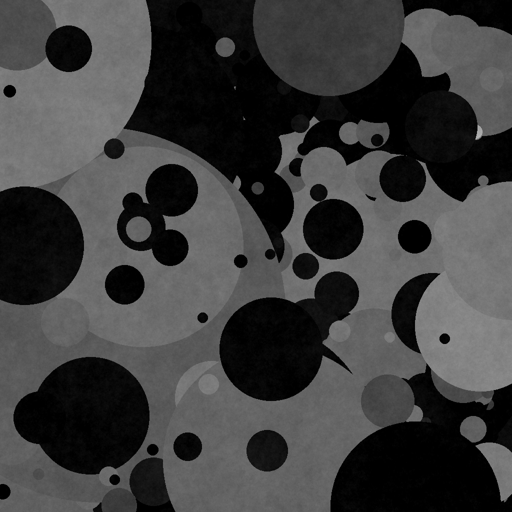

In [5]:
idx = 0

print("Radius min: ", dead_leaves.r_min)
print("Radius max: ", dead_leaves.r_max)
print("Alpha used: ", dead_leaves.alpha)
print("Number of images: ", dead_leaves.len)
print(f"----------- idx: {idx} -----------")
print("Disk number: ", dead_leaves.imgs[idx].disk_number)
print("Width: ", dead_leaves.imgs[idx].width)
print("Height: ", dead_leaves.imgs[idx].height)
print("Radius mean: ", dead_leaves.imgs[idx].r_mean)
print(f"Ratio drawn: {dead_leaves.imgs[idx].ratio_drawn*100:.2f}%")
dead_leaves.imgs[idx].pil

## Statistical Overview

Look at some statistical image metric to check if you mimic the ones of a CT image.

### Color Distribution

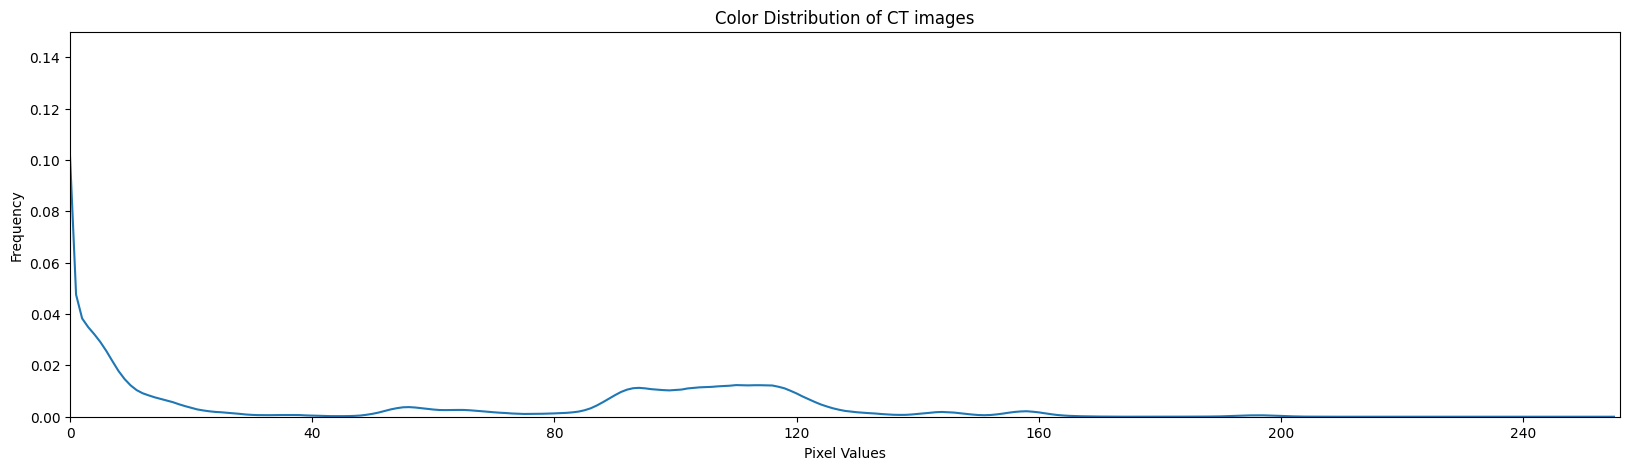

In [6]:
dl_color_hist = dead_leaves.color_histogram(plot=True)

### Directional Gradient

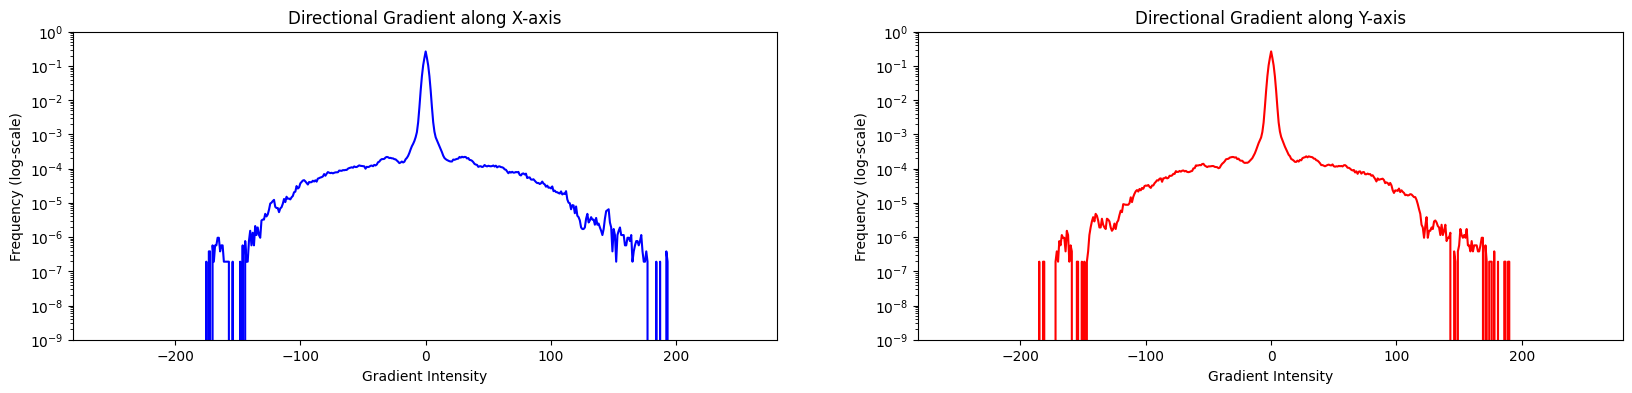

In [7]:
dl_grad_dist_x, dl_grad_dist_y, dl_grad_intensity = dead_leaves.directional_gradient(plot=True)

### Fourier Analysis

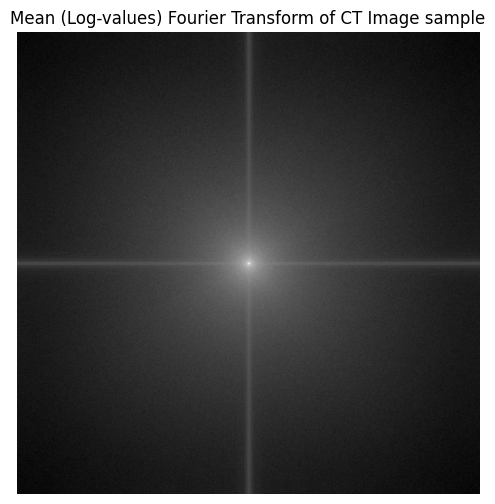

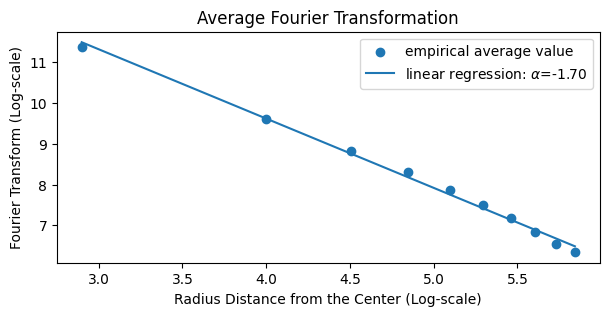

In [8]:
dl_alpha = dead_leaves.fourier_transform_analysis(plot=True)

## Store DL images

In [9]:
# Fix the path to store the dl images
path = "data/train/dl_images_bis/"
 
# Store the image in disk
# store_dl_disk(path, dead_leaves.imgs)

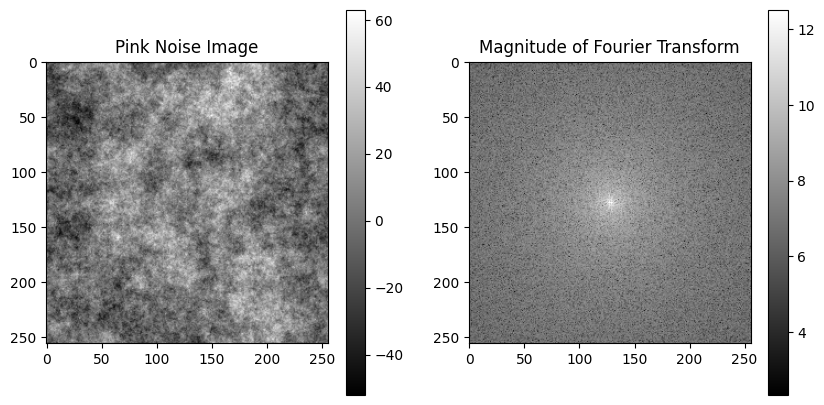

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/70085015/how-to-generate-2d-colored-noise

# Define the size of the image
image_size = 256

# Generate white noise image
whitenoise = np.random.normal(size=(256, 256)) * 600

# Compute 2D Fourier transform
ft_arr = np.fft.fftshift(np.fft.fft2(whitenoise))

_x, _y = np.mgrid[0:ft_arr.shape[0], 0:ft_arr.shape[1]]
f = np.hypot(_x - ft_arr.shape[0] / 2, _y - ft_arr.shape[1] / 2)
f[f == 0] = 1
f = f

pink_ft_arr = np.nan_to_num(ft_arr / f, nan=0, posinf=0, neginf=0)

pinknoise = np.fft.ifft2(np.fft.ifftshift(pink_ft_arr)).real.astype(int)

# Plot the white noise image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pinknoise, cmap='gray')
plt.title('Pink Noise Image')
plt.colorbar()

# Plot the magnitude of the Fourier transform
plt.subplot(1, 2, 2)
plt.imshow(np.log(np.abs(pink_ft_arr)), cmap='gray')
plt.title('Magnitude of Fourier Transform')
plt.colorbar()

plt.show()


In [11]:
# Generate the empty/background image
image = Image.new("L", size=(500, 500), color=0)
draw = ImageDraw.Draw(image)

draw.ellipse(xy=(100, 100, 400, 400),
             fill=125)

draw.ellipse(xy=(30, 25, 80, 75),
             fill=256)

In [12]:
def _add_brownian_noise(image: Image, xy: tuple, noise_var: int) -> Image:
    """Add the brownian noise to the current added object."""
    # Convert PIL image to NumPy array
    image_array = np.array(image, dtype=np.float64)

    # Use PIL image to retrieve the position of the circle just added
    circle_tracker = Image.new("1", size=image_array.shape, color=0)
    circle_track = ImageDraw.Draw(circle_tracker)
    circle_track.ellipse(xy=xy,
                         fill=1)
    mask = np.array(circle_tracker) == 1

    # Compute the brownian noise to add into image
    brownian_noise = _brownian_noise(size=image_array.shape,
                                     noise_var=noise_var,
                                     mask=mask)
    # Add the noise to the image
    image_array += brownian_noise

    # Make sure no values exceed 255
    image_array = np.clip(image_array, 0, 255).astype(np.uint8)

    # Convert NumPy array back to PIL image
    image = Image.fromarray(image_array, mode='L')

    return image


def _brownian_noise(size: tuple, noise_var: int, mask: np.ndarray) -> np.ndarray:
    """Create an array of image size with noise only where the disk has been added."""
    # First compute the big brownian noise of image size
    brownian_noise = _create_brownian_noise(size=size,
                                            noise_var=noise_var)

    plt.imshow(brownian_noise.astype(int), cmap='grey')
    plt.colorbar()
    plt.show()
    # Then only keep the region of interest (roi) where the disk has been added
    brownian_noise[~mask] = 0

    return brownian_noise


def _create_brownian_noise(size: tuple, noise_var: int) -> np.ndarray:
    """Create a brownian noise to add texture to the synthetic image.
        reference: https://stackoverflow.com/questions/70085015/how-to-generate-2d-colored-noise"""
    # Generate white noise image
    whitenoise = np.random.normal(size=size) * noise_var
    # Compute 2D Fourier transform and shift it to the center
    ft_arr = np.fft.fftshift(np.fft.fft2(whitenoise))
    # Pass the white noise into brownian noise
    _x, _y = np.mgrid[0:ft_arr.shape[0], 0:ft_arr.shape[1]]
    f = np.hypot(_x - ft_arr.shape[0] / 2, _y - ft_arr.shape[1] / 2)
    f[f == 0] = 1  # just to delete the 0 in the center
    brownian_ft_arr = np.nan_to_num(ft_arr / f, nan=0, posinf=0, neginf=0)
    # Come back to image level
    brownian_noise = np.fft.ifft2(np.fft.ifftshift(brownian_ft_arr)).real

    return brownian_noise


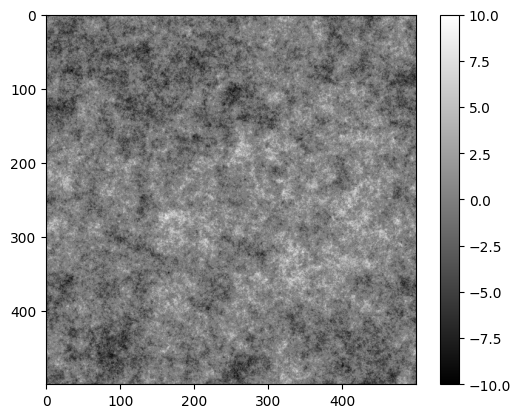

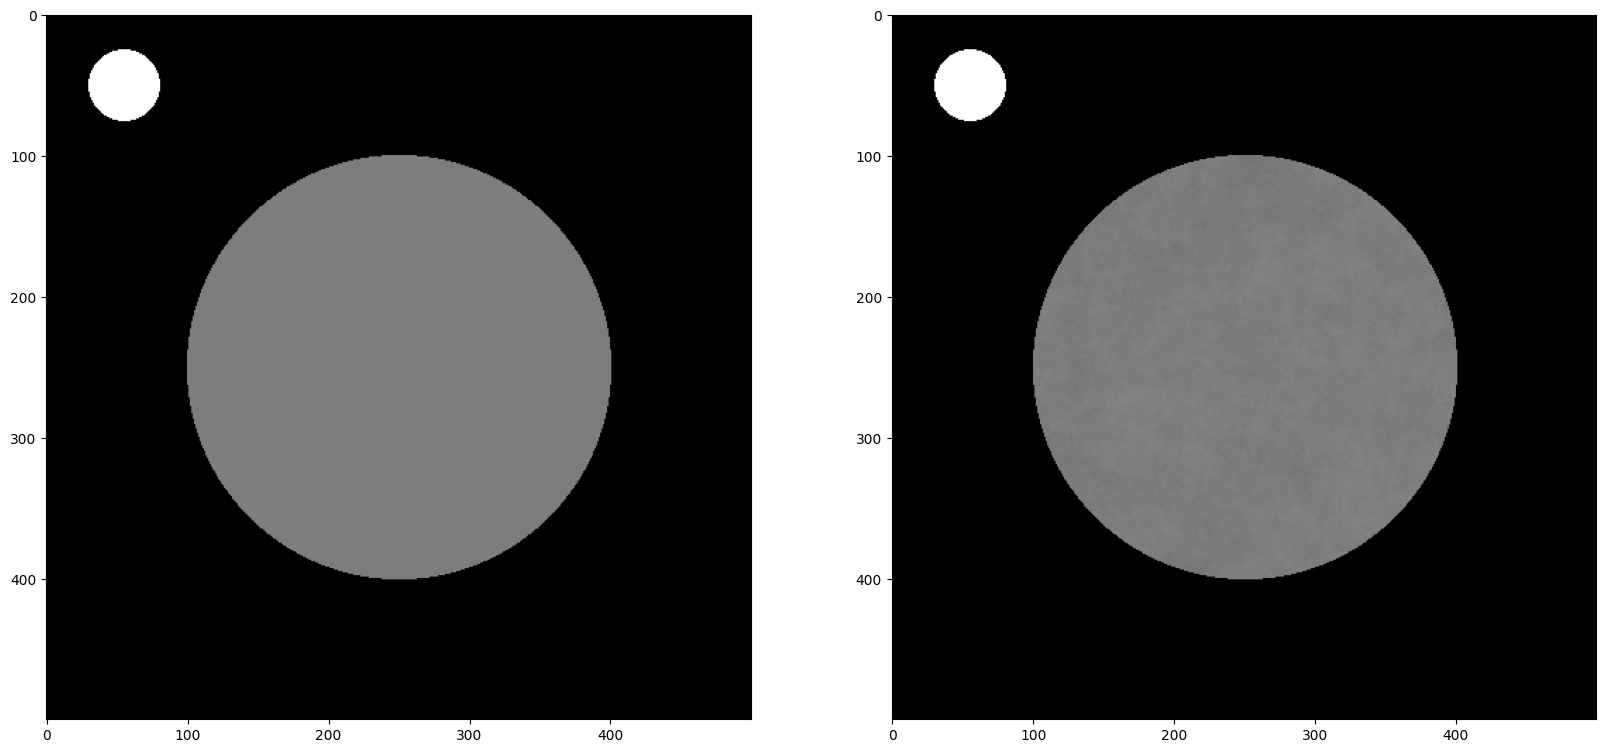

In [13]:
noised_img = _add_brownian_noise(image=image, xy=(100, 100, 400, 400), noise_var=200)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(image, cmap='grey')
axs[1].imshow(noised_img, cmap='grey')

plt.show()

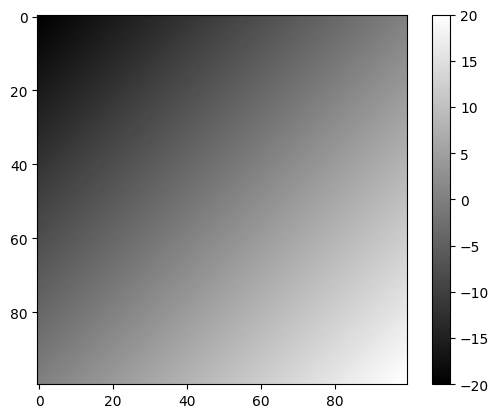

In [14]:
import numpy as np

def get_gradient_2d(start, stop, width, height):
    is_horizontal = np.random.choice([True, False])
    if is_horizontal:
        return np.tile(np.linspace(start, stop, width), (height, 1))
    else:
        return np.tile(np.linspace(start, stop, height), (width, 1)).T

grad = get_gradient_2d(-10, 10, 100, 100) + get_gradient_2d(-10, 10, 100, 100)

plt.imshow(grad, cmap='grey')
plt.colorbar()
plt.show()

In [15]:
np.random.choice(range(-30, -5))

-7